# Bank Customer Segmentation

The original dataset contains 1000 entries with 20 categorical/symbolic attributes.
The attributes are:
1. Age (numeric)
2. Sex (text: male, female)
3. Job (numeric: 0- unskilled and non-resident, 1-unskilled and resident, 2-skilled, 3-higly skilled)
4. Housing (text: own, rent, or free)
5. Saving Accounts (text: little, moderate, quite rich, rich)
6. Checking Account (numeric: dollar)
7. Credit Amount (numeric: dollar)
8. Duration (numeric: in month)
9. Purpose (text: car, furniture/equipment, radio/tv, domestic appliance, repairs, education, business, vacation/others).

In this script I will perform segmentation of USA Bank customers. 

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")

From sklearn, I will import necessary pre-processing tools and two clustering algorithms: KMeans and Affinity Propagation.

Let's read the data

In [17]:
data = pd.read_csv("german_credit_data.csv")

A visual control of the data.

In [18]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


It looks like the first column is an index column which I can delete. I'm going to chech how many missing values are in each column and of what data types they are. 

In [19]:
data.drop(data.columns[0], inplace=True, axis=1)
print("Database has {} obserwations (customers) and {} columns (attributes).".format(data.shape[0],data.shape[1]))
print("Missing values in each column:\n{}".format(data.isnull().sum()))
print("Columns data types:\n{}".format(data.dtypes))

Database has 1000 obserwations (customers) and 9 columns (attributes).
Missing values in each column:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64
Columns data types:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


Out of 8 columns 2 contains missing values. Probably there are customers who don't have one of these two accounts. Generally, there are 3 numeric variables and 5 categorical ones. Now I'm going to chech how many, and what are the possible (unique) values in each categorical column.

In [20]:
n_unique = data.nunique()
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [21]:
print("Unique values in each categorical column:")
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Unique values in each categorical column:
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


## Exploratory Data Analysis 

Below I'm going to define a function which will generate plots for three numeric variables with stratification by selected categorical column.

At the beginning le'ts look at scatter plots our 3 numerical varibales stratisfied by sex.

In [22]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

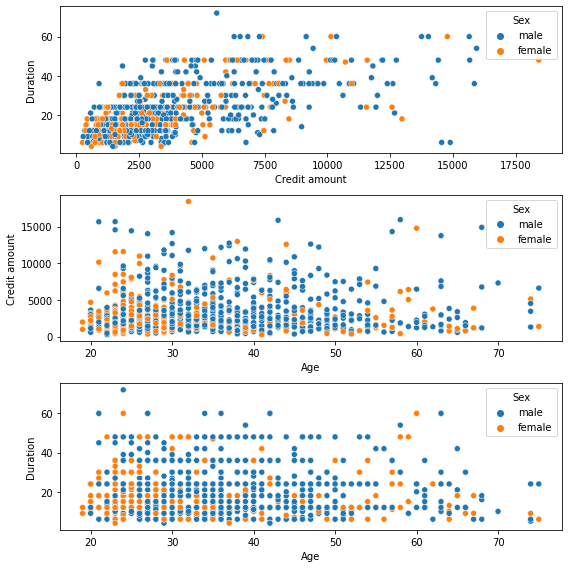

In [23]:
scatters(data, h="Sex")

The general impression is that women tend to be younger than men, however, the top plot shows that there is no clear difference between men and women in terms of amount and duration of the credit. 

From a visual inspection, it seems that there is some positive correlation between duration and amount of credit, which it makes sense.

AttributeError: 'JointGrid' object has no attribute 'annotate'

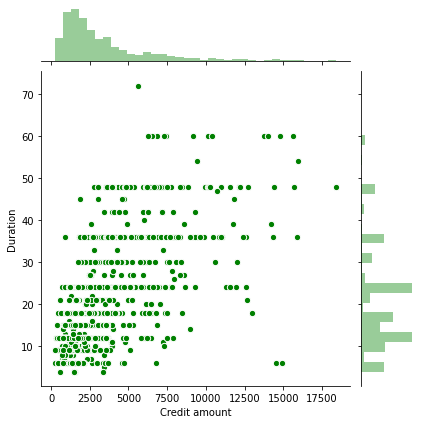

In [71]:
from scipy import stats

r1 = sns.JointGrid(x="Credit amount",y="Duration", data=data)
r1 = r1.plot_joint(plt.scatter, color="g", s=40, edgecolor="white")
r1 = r1.plot_marginals(sns.distplot, kde=False, color="g")
r1 = r1.annotate(stats.pearsonr)
#r1.ax_joint.text(xy=(1.0, 13.0), s="R^2: {:.2f}".format(rsquare(x[min_x:max_x],z[min_x:max_x])



Let's check the linear correlation between credit amount and duration.

The plot above shows a linear correlation with Pearson value of 0.62 and very small pv-value. That make's sense because usually, people take bigger credits for longer periods. 

Below I'm going to analyse linear regression plots with various categorisations.

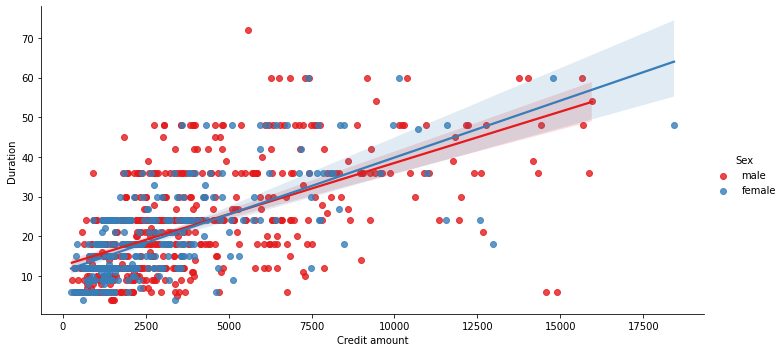

In [25]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=data, palette="Set1", aspect=2)
plt.show()

The plot above indicates that there is no significant difference between men and woman.

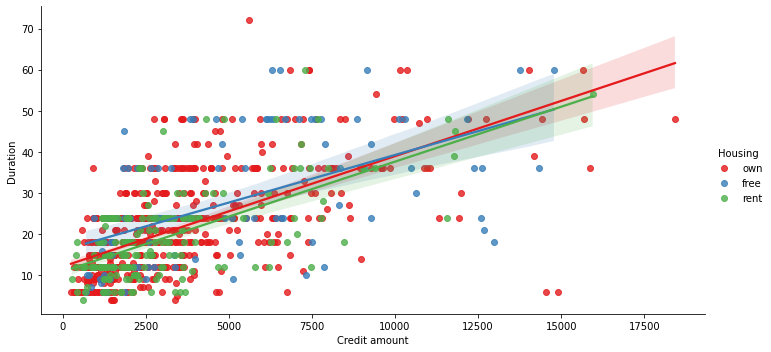

In [26]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=data, palette="Set1", aspect=2)
plt.show()

The plot above shows similarly that there is no difference between housing categories.

I'm going to plot how many credits were granted for various purposes. Most of credits were granted for car and radio/TV.

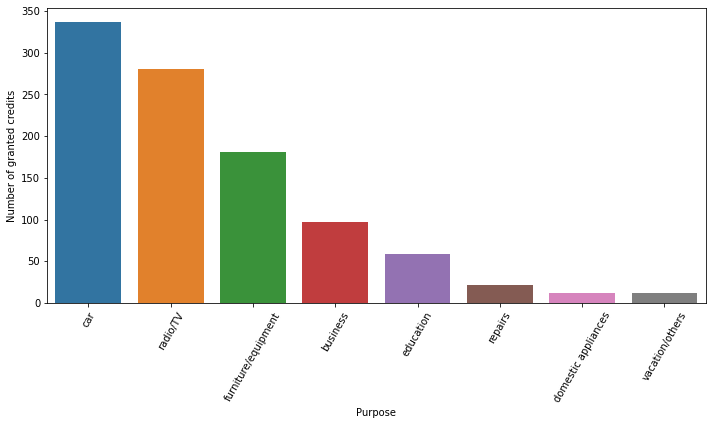

In [29]:
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Number of granted credits")
plt.tight_layout()

Let me generate boxplots for detailed analysis of categorical variables.

In [30]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

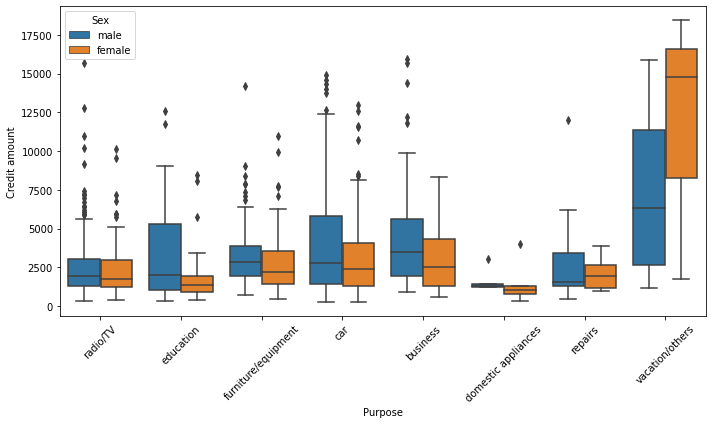

In [31]:
boxes("Purpose","Credit amount","Sex")

The plot aboce shows that the biggest amounts are taken for vacations/other, the smallest for domestic appliances. 
Most of them have outliers on the upper side of the boxes (higher amounts). In most of the cases there is no difference between men and women, despite category vacation/others. But just remember that there was very little number of credits granted in this category.

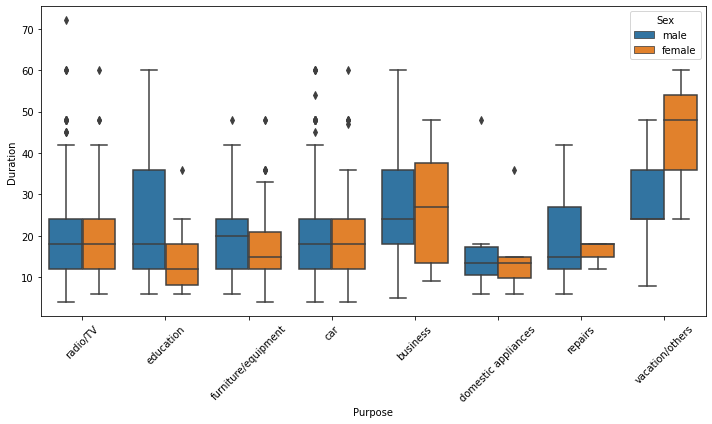

In [32]:
boxes("Purpose","Duration","Sex")

The boxplot above indicates that generally there is no difference in credit deration between men and woman. We can't see also clear trend between categories with observations that the shortest duration is for domestic appliance. It makes sense as it is an in aggreement with insights from the previous graph (credit amount).

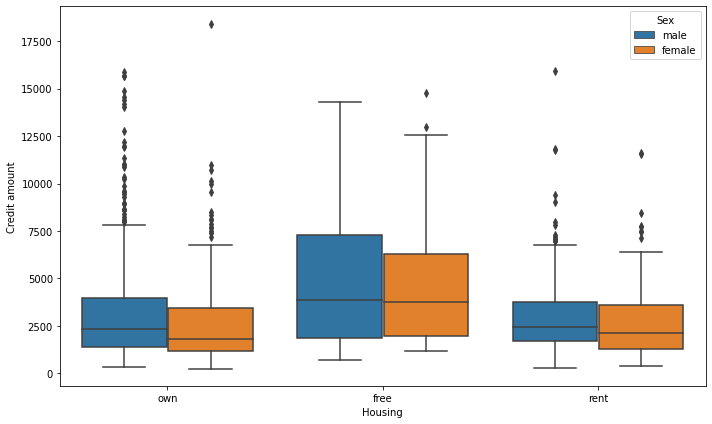

In [33]:
boxes("Housing","Credit amount","Sex",r=0)

In term of housing category, there is no big difference despite people having "free" housing tend to take slightly bigger credit amounts. 

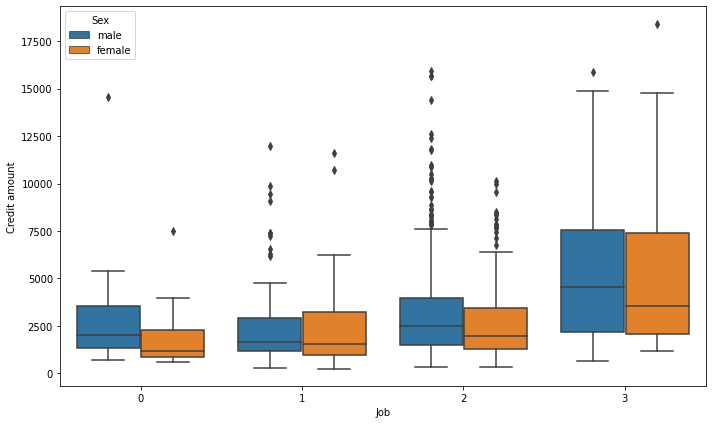

In [34]:
boxes("Job","Credit amount","Sex",r=0)

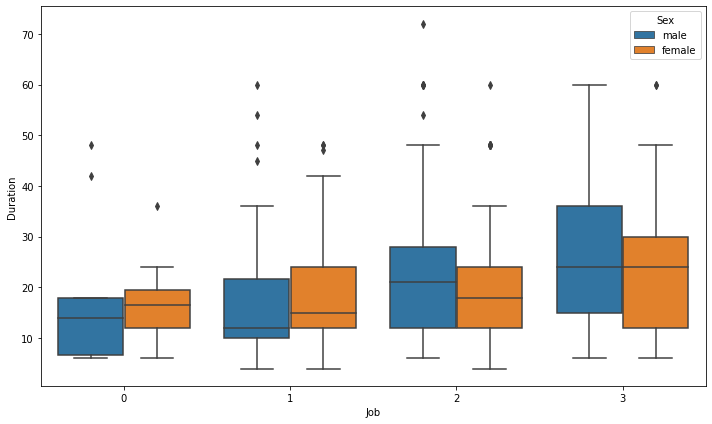

In [35]:
boxes("Job","Duration","Sex",r=0)

In term of job category once again there is no difference between men and women, but we can see that job category 3 tends to take bigger credit amounts for longer duration.

Let's use a 3D plot to see Credit, Age and Duration categories.

Text(0.5, 0, 'Age')

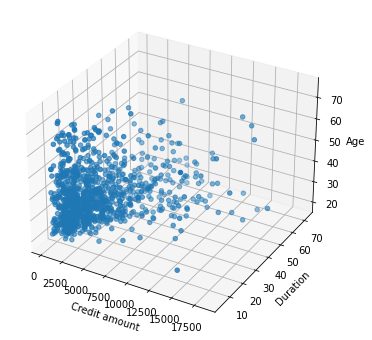

In [36]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Credit amount"], data["Duration"], data["Age"])
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

### Clustering with KMeans

For clustering, I'm going to create a subset containing only numerical variables (age, Credit Amount, Duration).

In [37]:
#Selecting columns for clusterisation with k-means
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

I'm going to create a function which plots three histogramns - one for each variable.

In [38]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

Let's look at the histograms.

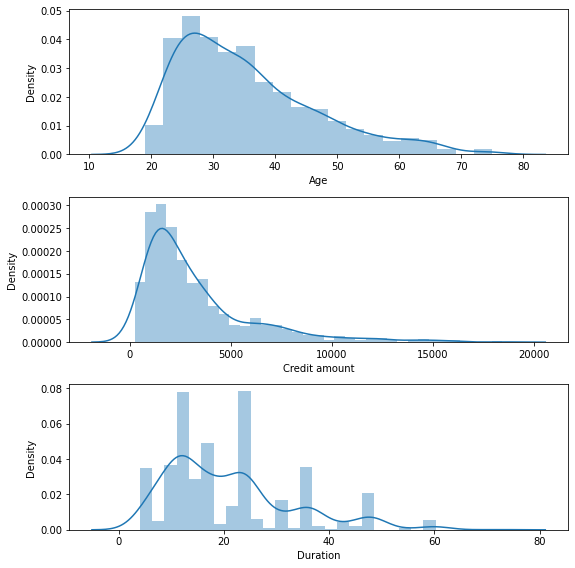

In [39]:
distributions(cluster_data)

Distributions are right-skewed. To obtain better results we should remove the skeweness by logarithmic transformation. After that let's see how they look like. 

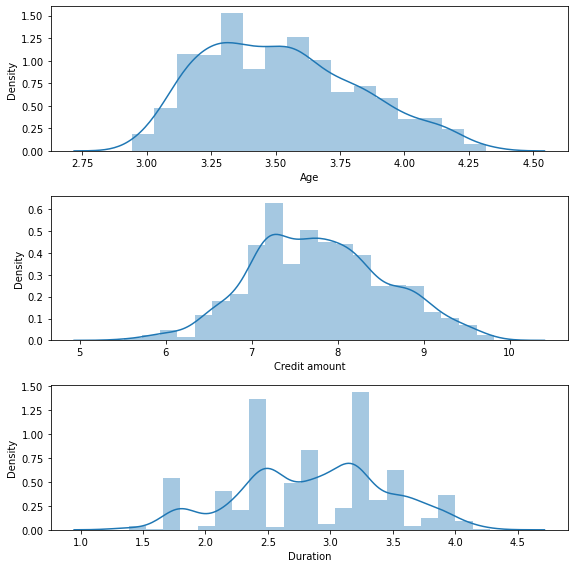

In [40]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

Indeed the skeweness has been eliminated.

The next step will be centering and scaling of variables - it is required by KMeans algorithm. I'm going to use StandardScaler from sklearn library.

In [73]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

I'm going to check how inertia changes for various number of clusters.

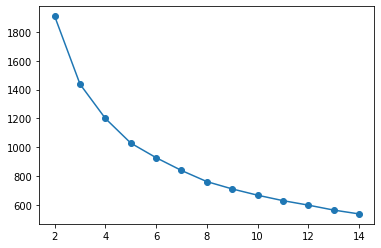

In [42]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')

The plot above shows that inertia decreases with increasing number of clusters. 

This method allows for assessment of cluster separations and fitting of each observation in its own cluster. The highest score the better is. I'm going to perform this analysis for various seeds as well.

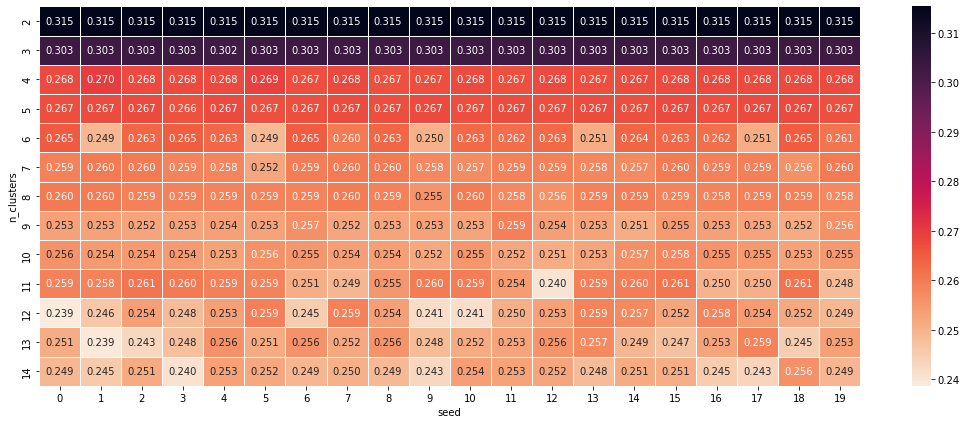

In [43]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

The heatmap above shows silhoutte scores for various combinations of random state and number of clusters. The highest scores are for 2 and 3 clusters and they are relatively insensitive to seed. 

I'm going to chose 3 clusters to get more insights into data and show them using a scatter plot.

In [44]:
kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

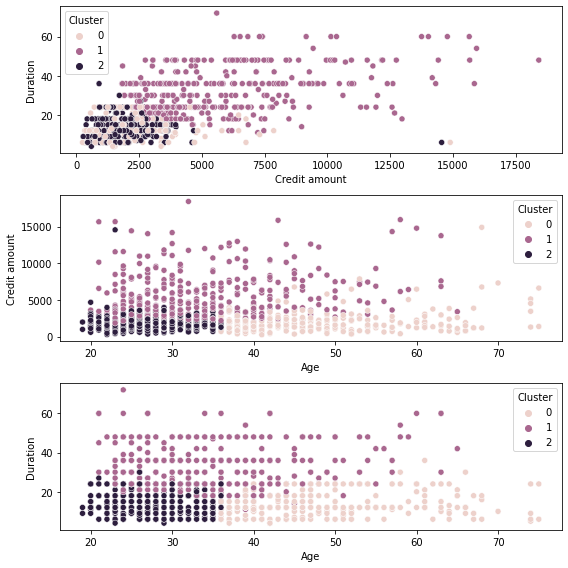

In [45]:
scatters(clustered_data, 'Cluster')

Plots above show three created clusters. Two bottom ones show relatively clear separation of clusters, but it is no so evident on the top one. 

I'm going to generate now a heatmap plot for easier business interpretation of customer segmentation. 

In [46]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,48.5,1970.3,13.9
1,34.0,5665.4,32.2
2,27.7,1736.3,14.3


- Cluster 0 -- Lower mean of credit amount, short duration, older customers
- Cluster 1 -- High mean of credit amount, long duration, middle-aged customers
- Cluster 2 -- Lower mean of credit amount, short duration, young customers

### Clustering with affinity propagation

In this algorithm there are two relevant parameters: preference and dumping. 
It means that we don't define upfront numbers of cluster, algorithm itself chooses their number. I will fix dumping and chec number of clusters in function of preference parameter. 

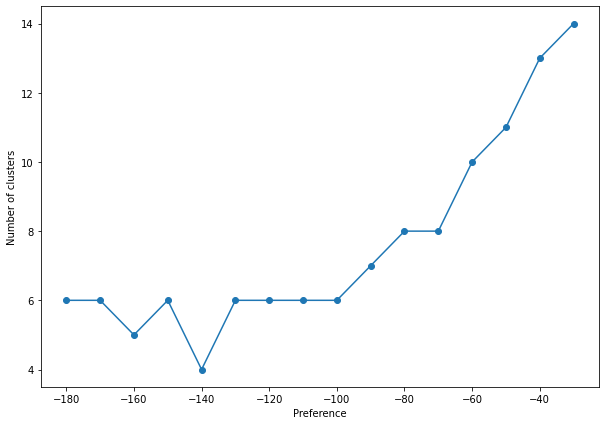

In [47]:
preferences = np.arange(-30,-190,-10)
clusters = []

for p in preferences:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(cluster_scaled)
    labels_af = pd.DataFrame(af.labels_)
    clusters.append(len(af.cluster_centers_indices_))

plt.figure(figsize=(10,7))
plt.xlabel("Preference")
plt.ylabel("Number of clusters")
plt.plot(preferences,clusters, marker='o')

Together with decreasing value of preference parameter number of clusters goes down as well and levels for very small preference values. I will check four clusters option.

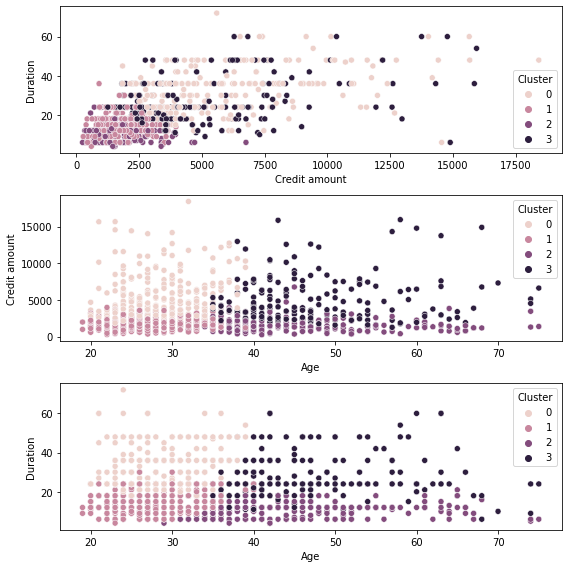

In [48]:
af = AffinityPropagation(preference=-140, damping=0.6, verbose=False).fit(cluster_scaled)
labels_af = pd.DataFrame(af.labels_)
n_clusters_ = len(af.cluster_centers_indices_)

clustered_data_af = cluster_data.assign(Cluster=labels_af)
scatters(clustered_data_af,'Cluster')

grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)

In [49]:
grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)
grouped_af

,Age,Credit amount,Duration
Cluster,,,
0,28.7,5593.7,32.2
1,27.9,1654.3,15.1
2,46.0,1551.7,10.7
3,47.5,4977.9,27.6


- Cluster 0 -- High mean of credit amount, long duration, younger customers.
- Cluster 1 -- Low mean of credit amount, short uration, younger customers.
- Cluster 2 -- Low mean of credit amount, short duration, older customers.
- Cluster 3 -- High mean of credit amount, middle-time duration, older customers.